We can model our control/switching problem as a switching linear regression (w/HMM) model

In this problem, we want to model the output dynamics:
$x_t = Ax_{t-1} + Bu_{t-1} + N(0,sigma)$

We assume that the joystick/state dynamics are fixed.

That is, $A$ is time invariant

Therefore, we can use a switching linear regression by noting the residuals can be written as:
$x_t - Ax_{t-1} = Bu_{t-1} + N(0,sigma)$

This means, are output variables of the switching regression:
$y_t | x_t, z_t ~ N(H(z_t)x_t+F(z_t),Sigma)$
Where $H(z_t)$ are regression weights that change according to the state

can actually be written as:
$y_t = x_t - Ax_{t-1}$

In terms of kinematics, these difference terms equate to either velocity or velocity and acceleration in N-cartesian coordinates

*What matters is choosing the correct $x_{t-1}$ combinations.


In [6]:
#Import libraries for HMM
import jax.numpy as jnp
import jax.random as jr

from itertools import count
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")

from dynamax.hidden_markov_model import LinearRegressionHMM

#Import data handling of monkey pac-man
import PacTimeOrig.DataHandling as DH
import PacTimeOrig.Methods.utils as pacutils

#Import standard libraries
import numpy as np
import pandas as pd
import os
from scipy.io import loadmat

In [26]:
A=loadmat('/Users/user/PycharmProjects/PacManMain/data/Simulation/A.mat')
B=loadmat('/Users/user/PycharmProjects/PacManMain/data/Simulation/B.mat')
ofc=loadmat('/Users/user/PycharmProjects/PacManMain/data/Simulation/simOFC.mat')
A=A['SetpointA']
B=B['SetpointB']

erA=A-ofc['x'][0:134,:]
erB=B-ofc['x'][0:134,:]
vel=np.array([np.gradient(ofc['x'][:,0],1),np.gradient(ofc['x'][:,1],1)]).transpose()

erA=jnp.array(erA)
erB=jnp.array(erB)
vel=jnp.array(vel)
inputs=np.hstack([erA,erB]).shape


NameError: name 'test_params' is not defined

In [3]:
# First set some global constants
num_states = 2
emission_dim = 3
covariate_dim = 2
num_timesteps = 1000

# Set up an iterator to yield JAX PRNGKey's
keys = map(jr.PRNGKey, count())

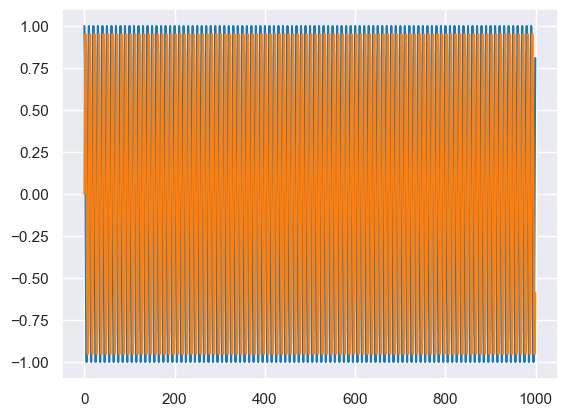

In [6]:
# Now make a time series of inputs. These are the inputs to the linear regression.
inputs = jnp.column_stack([jnp.cos(2 * jnp.pi * jnp.arange(num_timesteps) / 10),
                               jnp.sin(2 * jnp.pi * jnp.arange(num_timesteps) / 10)])

In [7]:
# Simulate data from a "true" model with randomly initialized parameters
# (Set the noise covariance to a pretty small value though, so the switches are easier to see.)
hmm = LinearRegressionHMM(num_states, covariate_dim, emission_dim)

transition_matrix = 0.9 * jnp.eye(num_states) + 0.1 / (num_states - 1) * (1 - jnp.eye(num_states))
emission_covariances = jnp.tile(0.1 * jnp.eye(emission_dim), (num_states, 1, 1))
true_params, _ = hmm.initialize(next(keys),
                                transition_matrix=transition_matrix,
                                emission_covariances=emission_covariances)

# Here we see our first difference from "regular" HMMs: this one takes `inputs` as a keyword argument
true_states, emissions = hmm.sample(true_params, next(keys), num_timesteps, inputs=inputs)

# Compute the marginal log probability of the emissions under the true model
true_lp = hmm.marginal_log_prob(true_params, emissions, inputs=inputs)

(0.0, 100.0)

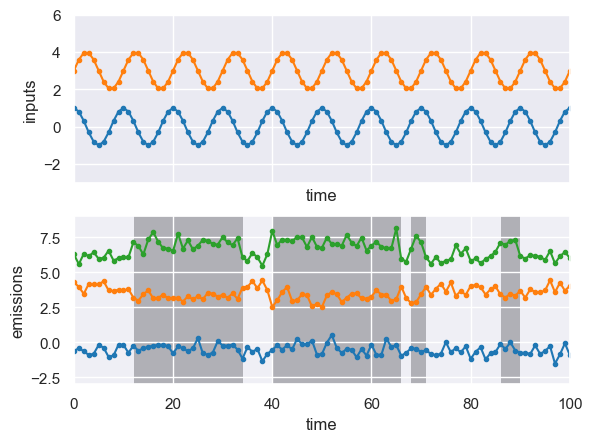

In [9]:
# Plot the inputs and emissions, along with the true states
fig, axs = plt.subplots(2, 1, sharex=True)

offsets = 3 * jnp.arange(covariate_dim)
axs[0].plot(inputs + offsets, '-', marker='.')
axs[0].set_xlim(0, num_timesteps)
axs[0].set_ylim(-3, 3 * covariate_dim)
axs[0].set_ylabel("inputs")
axs[0].set_xlabel("time")


offsets = 3 * jnp.arange(emission_dim)
axs[1].imshow(true_states[None, :],
              extent=(0, num_timesteps, -3, 3 * emission_dim),
              aspect="auto",
              cmap="Greys",
              alpha=0.25)
axs[1].plot(emissions + offsets, '-', marker='.')
axs[1].set_xlim(0, num_timesteps)
axs[1].set_ylim(-3, 3 * emission_dim)
axs[1].set_ylabel("emissions")
axs[1].set_xlabel("time")

# Zoom in on a smaller slice of data
axs[1].set_xlim(0, 100)

(0.0, 50.0)

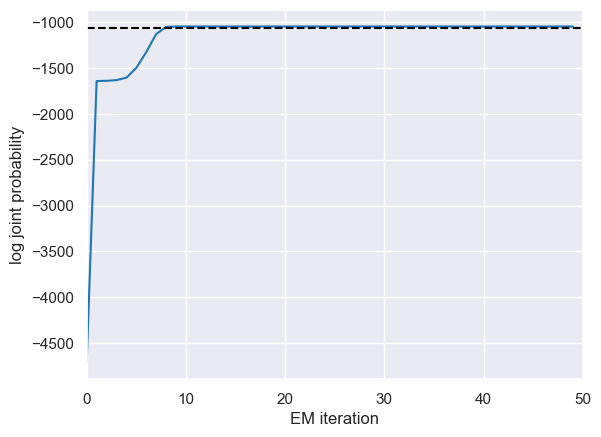

In [10]:
# Now fit another model to the simulated data
test_params, param_props = hmm.initialize(next(keys))

# To fit the model, give it a batch of emissions and a batch of corresponding inputs
test_params, lps = hmm.fit_em(test_params, param_props, emissions, inputs=inputs)

# Plot the log probability over EM iterations
plt.figure()
plt.plot(lps)
plt.plot([0, len(lps)], true_lp * jnp.ones(2), '--k')
plt.xlabel("EM iteration")
plt.ylabel("log joint probability")
plt.xlim([0, len(lps)])

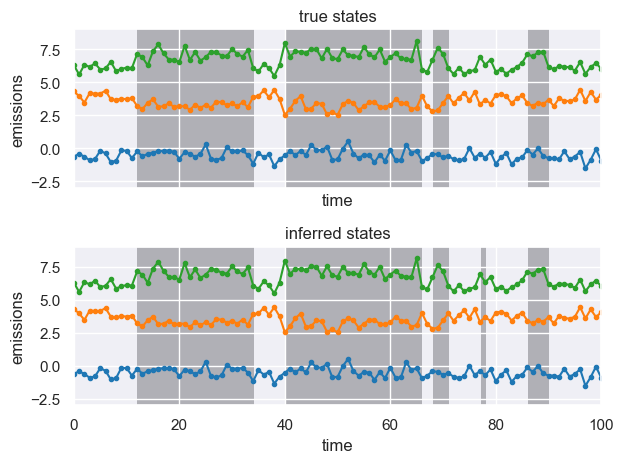

In [13]:
# Compute the most likely states
most_likely_states = hmm.most_likely_states(test_params, emissions, inputs=inputs)

# Compare them to the true states
fig, axs = plt.subplots(2, 1, sharex=True)

for i, states in enumerate([true_states, most_likely_states]):
    offsets = 3 * jnp.arange(emission_dim)
    axs[i].imshow(states[None, :],
                extent=(0, num_timesteps, -3, 3 * emission_dim),
                aspect="auto",
                cmap="Greys",
                alpha=0.25)
    axs[i].plot(emissions + offsets, '-', marker='.')
    axs[i].set_xlim(0, num_timesteps)
    axs[i].set_ylim(-3, 3 * emission_dim)
    axs[i].set_ylabel("emissions")
    axs[i].set_xlabel("time")
    axs[i].set_xlim(0, 100)

axs[0].set_title("true states")
axs[1].set_title("inferred states")
plt.tight_layout()

In [14]:
most_likely_states

Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

3